In [1]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from collections import Counter
from nltk.util import bigrams
from nltk.stem.porter import PorterStemmer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

import os
import zipfile
import shutil
import re

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout, LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Bidirectional

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Tensorflow version: 2.8.2
Keras version: 2.8.0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
train_data = pd.read_csv("/content/gdrive/MyDrive/IMDB/Train.csv")
test_data = pd.read_csv("/content/gdrive/MyDrive/IMDB/Test.csv")
valid_data = pd.read_csv("/content/gdrive/MyDrive/IMDB/Valid.csv")

In [4]:
train_data['label'].value_counts()

0    20019
1    19981
Name: label, dtype: int64

In [5]:
tokenizer = ToktokTokenizer()


In [6]:
stopword_list=stopwords.words('english')

In [7]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
  return re.sub('\[[^]]*\]', '', text)

def remove_emojis(text):
  return re.sub('\:')

def denoise_text(text):
  text = strip_html(text)
  text = remove_between_square_brackets(text)
  return text



In [8]:
train_data['text'], test_data['text'], valid_data['text'] = train_data['text'].apply(denoise_text), test_data['text'].apply(denoise_text), valid_data['text'].apply(denoise_text)

In [9]:
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
train_data['text'],test_data['text'], valid_data['text'] =train_data['text'].apply(remove_special_characters), test_data['text'].apply(remove_special_characters), valid_data['text'].apply(remove_special_characters) 

In [10]:
train_data['text']

0        I grew up b 1965 watching and loving the Thund...
1        When I put this movie in my DVD player and sat...
2        Why do people who do not know what a particula...
3        Even though I have great interest in Biblical ...
4        Im a die hard Dads Army fan and nothing will e...
                               ...                        
39995    Western Union is something of a forgotten clas...
39996    This movie is an incredible piece of work It e...
39997    My wife and I watched this movie because we pl...
39998    When I first watched Flatliners I was amazed I...
39999    Why would this film be so good but only gross ...
Name: text, Length: 40000, dtype: object

In [11]:
# Defining function to change all the reviews in lower case
def change_case(data):
  data = data.lower()
  return data

In [12]:
## Changing all the characters in the review texts in lowercase as case of a character makes no difference in the content of the review
train_data['text'], test_data['text'], valid_data['text'] = train_data['text'].apply(change_case), test_data['text'].apply(change_case), valid_data['text'].apply(change_case)

In [13]:
train_data['text']

0        i grew up b 1965 watching and loving the thund...
1        when i put this movie in my dvd player and sat...
2        why do people who do not know what a particula...
3        even though i have great interest in biblical ...
4        im a die hard dads army fan and nothing will e...
                               ...                        
39995    western union is something of a forgotten clas...
39996    this movie is an incredible piece of work it e...
39997    my wife and i watched this movie because we pl...
39998    when i first watched flatliners i was amazed i...
39999    why would this film be so good but only gross ...
Name: text, Length: 40000, dtype: object

#### Tokenizing the reviews using word tokenizer

In [14]:
nltk.download('punkt')
def stemSentence(sentence):
    sentence=word_tokenize(sentence)
    return sentence

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [15]:
train_data['text'], test_data['text'], valid_data['text'] = train_data['text'].apply(stemSentence), test_data['text'].apply(stemSentence), valid_data['text'].apply(stemSentence)

In [16]:
train_data['text']

0        [i, grew, up, b, 1965, watching, and, loving, ...
1        [when, i, put, this, movie, in, my, dvd, playe...
2        [why, do, people, who, do, not, know, what, a,...
3        [even, though, i, have, great, interest, in, b...
4        [im, a, die, hard, dads, army, fan, and, nothi...
                               ...                        
39995    [western, union, is, something, of, a, forgott...
39996    [this, movie, is, an, incredible, piece, of, w...
39997    [my, wife, and, i, watched, this, movie, becau...
39998    [when, i, first, watched, flatliners, i, was, ...
39999    [why, would, this, film, be, so, good, but, on...
Name: text, Length: 40000, dtype: object

#### Removing the stopwords and then lemmatizing the dataset.

In [17]:
def remove_stopwords(text):
  text = [t for t in text if t not in stopword_list]
  return text
def lemmatize(text):
  text = ' '.join([WordNetLemmatizer().lemmatize(t) for t in text])
  return text



In [18]:
train_data['text'], test_data['text'], valid_data['text'] = train_data['text'].apply(remove_stopwords), test_data['text'].apply(remove_stopwords), valid_data['text'].apply(remove_stopwords)

In [19]:
train_data

,text,label
0,"[grew, b, 1965, watching, loving, thunderbirds...",0
1,"[put, movie, dvd, player, sat, coke, chips, ex...",0
2,"[people, know, particular, time, past, like, f...",0
3,"[even, though, great, interest, biblical, movi...",0
4,"[im, die, hard, dads, army, fan, nothing, ever...",1
...,...,...
39995,"[western, union, something, forgotten, classic...",1
39996,"[movie, incredible, piece, work, explores, eve...",1
39997,"[wife, watched, movie, plan, visit, sicily, st...",0
39998,"[first, watched, flatliners, amazed, necessary...",1


In [20]:
train_data['text'], test_data['text'], valid_data['text'] = train_data['text'].apply(lemmatize), test_data['text'].apply(lemmatize), valid_data['text'].apply(lemmatize)

In [21]:
train_data

,text,label
0,grew b 1965 watching loving thunderbird mate s...,0
1,put movie dvd player sat coke chip expectation...,0
2,people know particular time past like feel nee...,0
3,even though great interest biblical movie bore...,0
4,im die hard dad army fan nothing ever change g...,1
...,...,...
39995,western union something forgotten classic west...,1
39996,movie incredible piece work explores every noo...,1
39997,wife watched movie plan visit sicily stromboli...,0
39998,first watched flatliners amazed necessary feat...,1


#### Most common distrribution of words

In [22]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [23]:
words_list = []
for i in range(0,len(train_data["text"])):
  for w in train_data["text"][i]:
    words_list.append(w)

In [24]:
### Function to get the words with the highest frequency
def get_top_n_words(x, n=None):
    vec = CountVectorizer(stop_words='english').fit(x)
    bag_of_words = vec.transform(x)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [25]:
common_words_uni = get_top_n_words(train_data["text"], 30)
common_words_uni

[('movie', 79342),
 ('film', 71702),
 ('like', 31959),
 ('time', 23535),
 ('good', 23001),
 ('character', 22116),
 ('story', 19359),
 ('make', 18950),
 ('really', 18391),
 ('scene', 16527),
 ('people', 14402),
 ('great', 14194),
 ('bad', 14106),
 ('dont', 13273),
 ('way', 13229),
 ('thing', 12934),
 ('think', 12040),
 ('life', 11538),
 ('know', 11295),
 ('watch', 10913),
 ('love', 10839),
 ('seen', 10505),
 ('actor', 10464),
 ('plot', 10347),
 ('say', 10256),
 ('look', 10154),
 ('little', 9958),
 ('acting', 9954),
 ('end', 9879),
 ('best', 9818)]

In [26]:
df_freq = pd.DataFrame(common_words_uni, columns = ['unigram', 'Count'])
df_freq

,unigram,Count
0,movie,79342
1,film,71702
2,like,31959
3,time,23535
4,good,23001
5,character,22116
6,story,19359
7,make,18950
8,really,18391
9,scene,16527


In [27]:
def get_top_n_bigram(x, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(x)
    bag_of_words = vec.transform(x)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [28]:
common_words_bi = get_top_n_bigram(train_data["text"], 30)
common_words_bi

[('ive seen', 2677),
 ('look like', 2416),
 ('special effect', 1755),
 ('dont know', 1737),
 ('movie like', 1587),
 ('main character', 1514),
 ('year old', 1292),
 ('good movie', 1238),
 ('horror movie', 1218),
 ('film like', 1164),
 ('waste time', 1153),
 ('watch movie', 1139),
 ('horror film', 1129),
 ('bad movie', 1068),
 ('make movie', 1061),
 ('im sure', 1058),
 ('dont think', 1028),
 ('year ago', 1006),
 ('low budget', 1000),
 ('new york', 988),
 ('worst movie', 930),
 ('bad guy', 928),
 ('movie really', 918),
 ('feel like', 915),
 ('pretty good', 871),
 ('high school', 865),
 ('like movie', 861),
 ('make sense', 854),
 ('watching movie', 835),
 ('great movie', 833)]

In [29]:
df_freq_1 = pd.DataFrame(common_words_bi, columns = ['bigram', 'Count'])
df_freq_1

,bigram,Count
0,ive seen,2677
1,look like,2416
2,special effect,1755
3,dont know,1737
4,movie like,1587
5,main character,1514
6,year old,1292
7,good movie,1238
8,horror movie,1218
9,film like,1164


#### Visualizing unigram and bigrams frequency.

<BarContainer object of 30 artists>

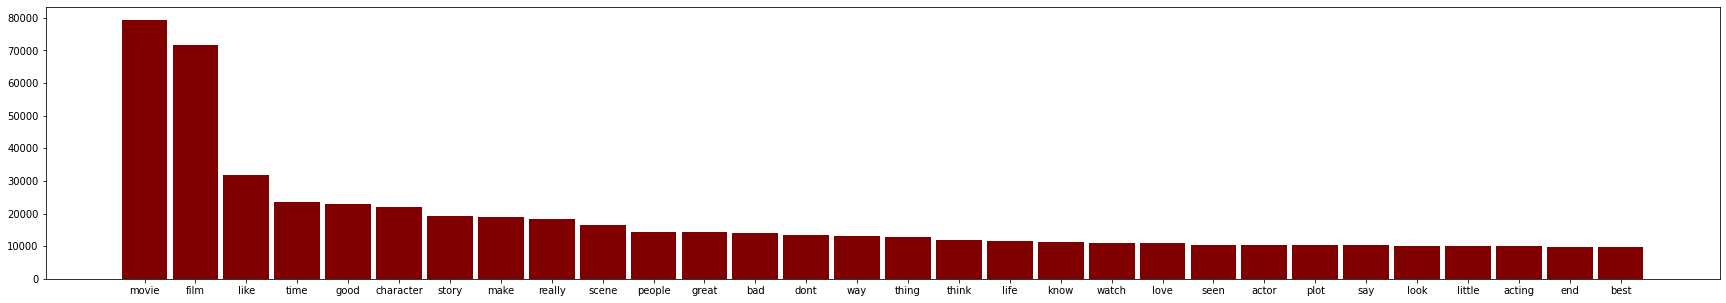

In [30]:
## Plotting unigram frequeny
fig = plt.figure(figsize = (30, 5))
plt.bar(df_freq["unigram"], df_freq["Count"], color ='maroon',
        width = 0.9)

<BarContainer object of 30 artists>

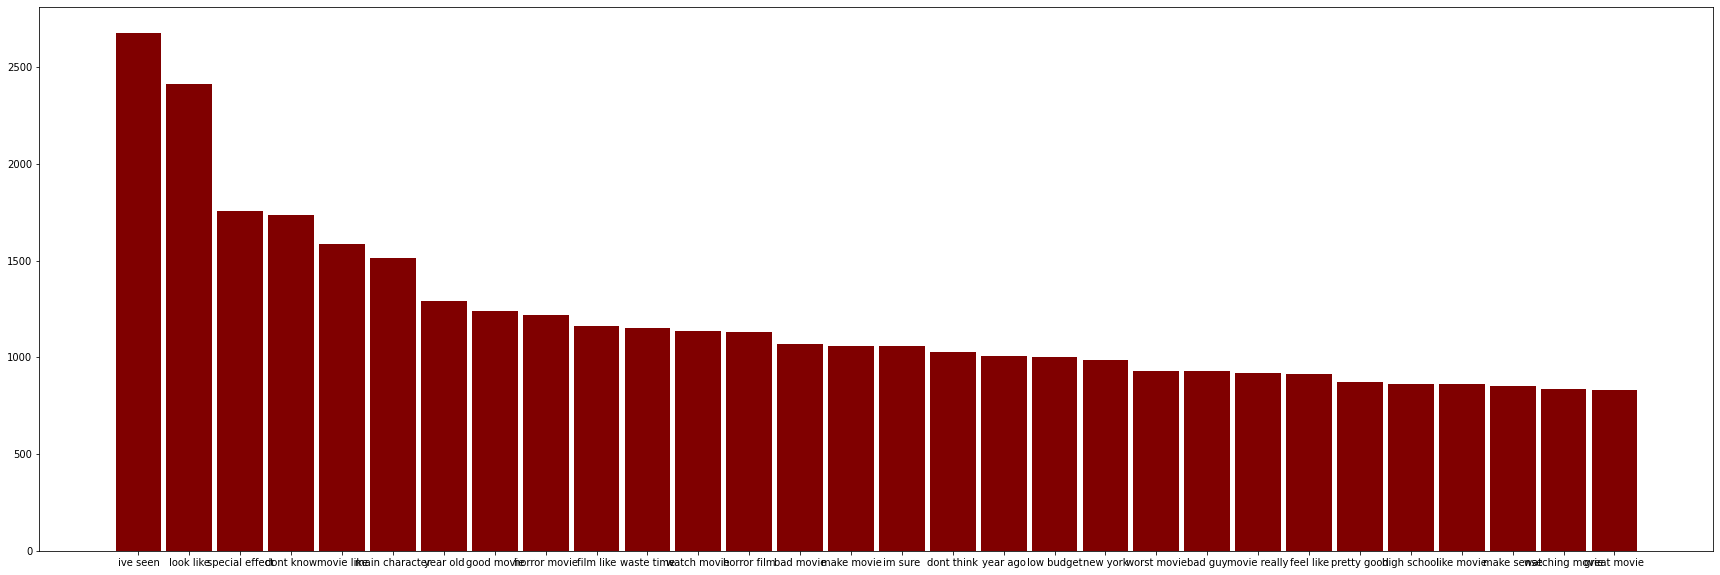

In [31]:
## Plotting bigram frequeny
fig = plt.figure(figsize = (30, 10))
plt.bar(df_freq_1["bigram"], df_freq_1["Count"], color ='maroon',
        width = 0.9)

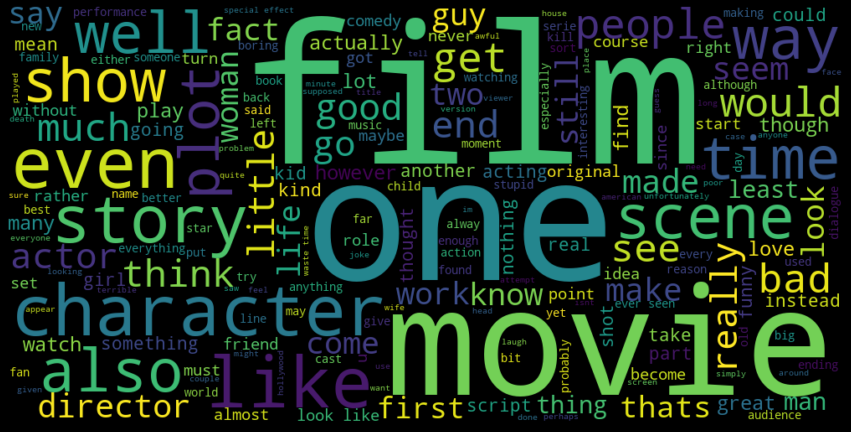

In [32]:
### Visualizing words which denote negative sentiments
pos_freq =' '.join(train_data[train_data['label'] == 0].text)

wordcloud = WordCloud(stopwords=stopword_list, width=1000, height=500).generate(pos_freq)

plt.figure(figsize=(15,10), facecolor='k')

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")

plt.show()

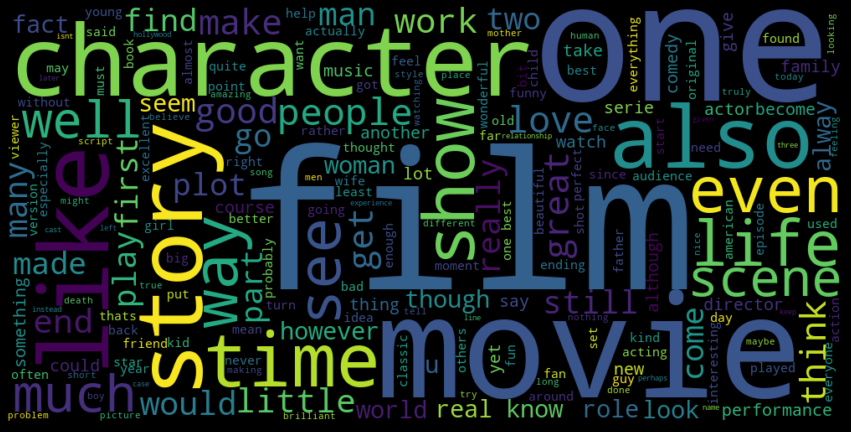

In [33]:
### Visualizing words which denote positive sentiments
pos_freq =' '.join(train_data[train_data['label'] == 1].text)

wordcloud = WordCloud(stopwords=stopword_list, width=1000, height=500).generate(pos_freq)

plt.figure(figsize=(15,10), facecolor='k')

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")

plt.show()

#### Splitting the data into test and train set

In [34]:
x_train = train_data['text']
y_train = train_data['label']

x_test = test_data['text']
y_test = test_data['label']


##### Writing a function to find the length of the corpus and return 


In [35]:

corpus =[]
for text in train_data['text']:
    words = [word.lower() for word in nltk.word_tokenize(text)]
    corpus.append(words)
    num_words = len(corpus)


#### Processing the dataset to feed them as the input

In [36]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train,maxlen = 130,padding='post',truncating='post')

In [37]:
x_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test,maxlen = 130,padding='post',truncating='post')

#### LSTM model

In [38]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(input_dim=num_words,output_dim=32,input_length=130,trainable=True))

#model_lstm.add(LSTM(64,dropout=0.2,return_sequences=False))

#model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
#model_lstm.add(Dropout(0.2))

#model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
#model_lstm.add(Dropout(0.2))

#model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
#model_lstm.add(Dropout(0.2))

#model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
#model_lstm.add(Dropout(0.2))

#model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
#model_lstm.add(Dropout(0.2))

#model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
#model_lstm.add(Dropout(0.2))

#model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
#model_lstm.add(Dropout(0.2))

#model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
#model_lstm.add(Dropout(0.2))

##model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
##model_lstm.add(Dropout(0.2))

##model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
##model_lstm.add(Dropout(0.2))

##model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
##model_lstm.add(Dropout(0.2))

##model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
##model_lstm.add(Dropout(0.2))

##model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
#model_lstm.add(Dropout(0.2))

#model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
#model_lstm.add(Dropout(0.2))

#model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
#model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 64)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(units=1,activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 32)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,304,897
Trainable params: 1,304,897
Non-trainable params: 0
_________________________________________________________________


In [39]:
history1=model_lstm.fit(x_train, y_train,epochs =5, batch_size = 64)

Epoch 1/5
625/625 [==============================] - 13s 10ms/step - loss: 0.5053 - accuracy: 0.7268
Epoch 2/5
625/625 [==============================] - 7s 11ms/step - loss: 0.2519 - accuracy: 0.9083
Epoch 3/5
625/625 [==============================] - 5s 8ms/step - loss: 0.1632 - accuracy: 0.9471
Epoch 4/5
625/625 [==============================] - 6s 10ms/step - loss: 0.1136 - accuracy: 0.9674
Epoch 5/5
625/625 [==============================] - 5s 9ms/step - loss: 0.0921 - accuracy: 0.9747


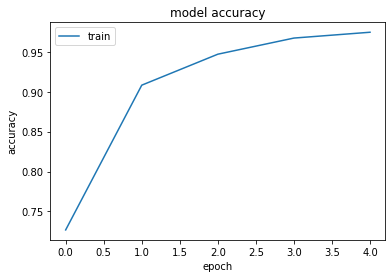

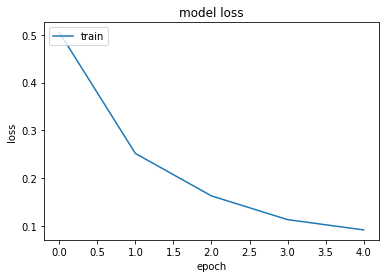

In [41]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
model_lstm.evaluate(x_test, y_test)

157/157 [==============================] - 1s 5ms/step - loss: 0.3906 - accuracy: 0.8752


[0.3906114399433136, 0.8751999735832214]

#### Creating the Bidirectional RNN model

In [43]:
model_brnn = Sequential()
model_brnn.add(tf.keras.layers.Embedding(input_dim=num_words,output_dim=64,input_length=130,trainable=True))

#model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
#model_brnn.add(Dropout(0.2))

#model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
#model_brnn.add(Dropout(0.2))

#model_brnn.add(Bidirectional(SimpleRNN(units = 100, activation = "tanh", return_sequences = True)))
#model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = False)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Dense(units=1,activation='sigmoid'))

model_brnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_brnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 130, 64)           2560000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              16512     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,576,641
Trainable params: 2,576,641
Non-trainable params: 0
_________________________________________________________________


In [45]:
history2 = model_brnn.fit(x_train, y_train,epochs = 3, batch_size = 64)

Epoch 1/3
625/625 [==============================] - 110s 177ms/step - loss: 0.5447 - accuracy: 0.7088
Epoch 2/3
625/625 [==============================] - 111s 177ms/step - loss: 0.3102 - accuracy: 0.8747
Epoch 3/3
625/625 [==============================] - 107s 171ms/step - loss: 0.1344 - accuracy: 0.9528


In [46]:
model_brnn.evaluate(x_test, y_test)

157/157 [==============================] - 5s 26ms/step - loss: 0.4661 - accuracy: 0.8252


[0.46613314747810364, 0.8252000212669373]

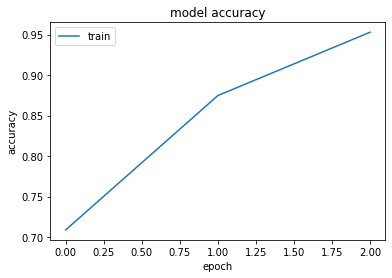

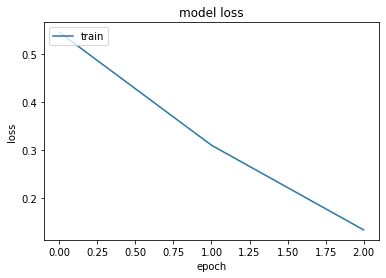

In [47]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()